<a href="https://colab.research.google.com/github/SMRayeed/Stock-Data-Analysis/blob/main/Nov26_lstm_gru_inidcators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import array
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from statsmodels.tsa.arima.model import ARIMA

from itertools import cycle
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf

## T E S L A

#### Company Data

In [2]:
company = "TSLA"
start_date = "2020-01-01"
end_date = "2023-01-01"

#### Load Functions

In [3]:
def set_df(data) :
  df = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close', 'Adj Close':'adj_close','Volume':'volume'})
  return df

In [4]:
def data_checker(df) :
  assert df.isnull().values.sum() == 0 , 'Value MISSING'
  assert df.isna().values.sum() == 0, 'Value N/A'

In [5]:
def date_col(df) :
  df['date'] = pd.to_datetime(df.date)
  return df

In [6]:
def data_download(company, start_date, end_date) :
  df = yf.download(company, start=start_date, end=end_date)
  df = df.reset_index()
  return df

#### Main

In [7]:
df = data_download(company, start_date, end_date)
data = df.copy()
data = set_df(data)

data_checker(data)
data = date_col(data)

[*********************100%%**********************]  1 of 1 completed


In [8]:
data.head(5)

,date,open,high,low,close,adj_close,volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


#### Indicators

In [9]:
def calculate_ma(data) :
  data['ma7']  = data['close'].rolling(window = 7).mean()
  data['ma21'] = data['close'].rolling(window = 21).mean()

In [10]:
def calculate_macd(data):
    data['26ema'] = data['close'].ewm(span=26).mean()
    data['12ema'] = data['close'].ewm(span=12).mean()
    data['MACD'] = (data['12ema'] - data['26ema'])

In [11]:
def calculate_bollinger_bands(data):
    data['20sd'] = data['close'].rolling(window=20).std()
    data['upper_band'] = (data['close'].rolling(window=20).mean()) + (data['20sd'] * 2)
    data['lower_band'] = (data['close'].rolling(window=20).mean()) - (data['20sd'] * 2)

In [12]:
def calculate_ema(data):
    data['ema'] = data['close'].ewm(com=0.5).mean()

In [13]:
def calculate_momentum(data):
    data['momentum'] = (data['close'] / 100) - 1

In [14]:
def calculate_rsi_30(data):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi_30'] = 100 - (100 / (1 + rs))

In [15]:
def calculate_cci_30(data):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=30).mean()
    mean_deviation = (abs(tp - sma_tp)).rolling(window=30).mean()
    data['cci_30'] = (tp - sma_tp) / (0.015 * mean_deviation)

In [16]:
def calculate_dx_30(data):
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    high_gain = high_diff.where(high_diff > low_diff, 0)
    low_loss = -low_diff.where(low_diff > high_diff, 0)
    avg_high_gain = high_gain.rolling(window=14).mean()
    avg_low_loss = low_loss.rolling(window=14).mean()
    rs = avg_high_gain / avg_low_loss
    data['dx_30'] = (100 * (avg_high_gain - avg_low_loss) / (avg_high_gain + avg_low_loss)).abs()

In [17]:
def calculate_close_30(data):
    data['close_30'] = data['close'].rolling(window=30).mean()

In [18]:
def calculate_close_60(data):
    data['close_60'] = data['close'].rolling(window=60).mean()

In [19]:
def calculate_volatility(data, window_size):
    data['Log_Returns'] = data['close'].pct_change().apply(lambda x: np.log(1 + x))
    vol_col = 'Vola'+str(window_size)+'d'
    data[vol_col] = data['Log_Returns'].rolling(window=window_size).std() * np.sqrt(252)
    data[['close', vol_col]]

In [20]:
def calculate_volume_indicator(data, window_size):
    data['Vol_Pct_Change'] = data['volume'].pct_change()
    volu_col = 'Volu'+str(window_size)+'d_ff'
    data[volu_col] = data['Vol_Pct_Change'].rolling(window=window_size).std() * np.sqrt(252)

In [21]:
def calculate_average_true_range(data, window=14):
  high_low = data['high'] - data['low']
  high_close = np.abs(data['high'] - data['close'].shift())
  low_close = np.abs(data['low'] - data['close'].shift())
  true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
  average_true_range = true_range.rolling(window=window).mean()
  data['atr'] = average_true_range

In [22]:
calculate_ma(data)
calculate_macd(data)
calculate_bollinger_bands(data)
calculate_ema(data)
calculate_momentum(data)
calculate_rsi_30(data)
calculate_cci_30(data)
calculate_dx_30(data)
calculate_close_30(data)
calculate_close_60(data)
calculate_volatility(data,10)
calculate_volatility(data,30)
calculate_volatility(data,60)
calculate_volume_indicator(data,10)
calculate_volume_indicator(data,30)
calculate_volume_indicator(data,60)
calculate_average_true_range(data)

In [23]:
data.head(5)

,date,open,high,low,close,adj_close,volume,ma7,ma21,26ema,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,NaN,NaN,28.684000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,NaN,NaN,29.125346,...,NaN,0.029203,NaN,NaN,NaN,0.865119,NaN,NaN,NaN,NaN
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,NaN,NaN,29.476488,...,NaN,0.019072,NaN,NaN,NaN,-0.430042,NaN,NaN,NaN,NaN
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,NaN,NaN,29.978062,...,NaN,0.038067,NaN,NaN,NaN,0.764739,NaN,NaN,NaN,NaN
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,NaN,NaN,30.634646,...,NaN,0.048033,NaN,NaN,NaN,0.741647,NaN,NaN,NaN,NaN


In [24]:
data = data.ffill().bfill()

#### Preprocessing

In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [26]:
df_indicators = data.drop(['open', 'high', 'low', 'adj_close'], axis=1)

In [27]:
df_indicators

,date,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
0,2020-01-02,28.684000,142981500,30.909524,35.243936,28.684000,28.684000,0.000000,3.603846,42.045259,...,41.697144,0.029203,0.606102,0.975432,1.214309,0.865119,9.421464,9.917300,7.699974,1.653285
1,2020-01-03,29.534000,266677500,30.909524,35.243936,29.125346,29.144417,0.019071,3.603846,42.045259,...,41.697144,0.029203,0.606102,0.975432,1.214309,0.865119,9.421464,9.917300,7.699974,1.653285
2,2020-01-06,30.102667,151995000,30.909524,35.243936,29.476488,29.518422,0.041934,3.603846,42.045259,...,41.697144,0.019072,0.606102,0.975432,1.214309,-0.430042,9.421464,9.917300,7.699974,1.653285
3,2020-01-07,31.270666,268231500,30.909524,35.243936,29.978062,30.071537,0.093475,3.603846,42.045259,...,41.697144,0.038067,0.606102,0.975432,1.214309,0.764739,9.421464,9.917300,7.699974,1.653285
4,2020-01-08,32.809334,467164500,30.909524,35.243936,30.634646,30.815387,0.180741,3.603846,42.045259,...,41.697144,0.048033,0.606102,0.975432,1.214309,0.741647,9.421464,9.917300,7.699974,1.653285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2022-12-23,123.150002,166989700,140.234286,166.041905,165.275890,148.031122,-17.244768,22.371719,209.944438,...,195.450334,-0.017707,0.555239,0.629949,0.642863,-0.205153,4.272560,4.491879,4.391398,9.692856
752,2022-12-27,109.099998,208643400,133.295714,162.529524,161.114713,142.041718,-19.072995,25.204712,211.919424,...,192.847834,-0.121138,0.688963,0.688475,0.679976,0.249439,4.355063,4.496143,4.395667,10.126428
753,2022-12-28,112.709999,221070500,127.935715,159.186191,157.529179,137.529146,-20.000032,26.995549,212.095097,...,190.686334,0.032553,0.786921,0.704424,0.668337,0.059561,3.317387,4.433059,4.316031,10.157142
754,2022-12-29,121.820000,221923300,123.928573,156.376191,154.884054,135.112354,-19.771700,26.713017,207.886034,...,188.559334,0.077726,0.972776,0.750399,0.688591,0.003858,3.049045,4.431187,4.314512,10.494284


In [60]:
print(df_indicators.columns)

Index(['date', 'close', 'volume', 'ma7', 'ma21', '26ema', '12ema', 'MACD',
       '20sd', 'upper_band', 'lower_band', 'ema', 'momentum', 'rsi_30',
       'cci_30', 'dx_30', 'close_30', 'close_60', 'Log_Returns', 'Vola10d',
       'Vola30d', 'Vola60d', 'Vol_Pct_Change', 'Volu10d_ff', 'Volu30d_ff',
       'Volu60d_ff', 'atr'],
      dtype='object')


In [28]:
min_val = df_indicators['close'].min()
max_val = df_indicators['close'].max()

In [29]:
scaler = MinMaxScaler()
df_normalized = df_indicators.copy()
df_normalized[df_normalized.columns[1:]] = scaler.fit_transform(df_normalized[df_normalized.columns[1:]])

In [30]:
df_normalized.tail(3)

,date,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
753,2022-12-28,0.229674,0.216653,0.269587,0.370822,0.391849,0.317190,0.083223,0.487516,0.429376,...,0.473973,0.643768,0.352440,0.406914,0.389032,0.216550,0.092866,0.241586,0.208425,0.367166
754,2022-12-29,0.253282,0.217617,0.258683,0.362574,0.383805,0.310147,0.086828,0.482028,0.418886,...,0.467206,0.751847,0.451578,0.445731,0.409128,0.201439,0.074577,0.241369,0.208170,0.381723
755,2022-12-30,0.256806,0.145109,0.253000,0.352578,0.376663,0.304797,0.094923,0.464579,0.405496,...,0.460969,0.592445,0.454416,0.446038,0.408987,0.121979,0.099272,0.242791,0.212167,0.368122


In [31]:
df_time_series = df_normalized.set_index('date')

In [32]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series.iloc[:train_size], df_time_series.iloc[train_size:]

In [33]:
test.head(3)

,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
date,,,,,,,,,,,,,,,,,,,,,
2022-05-25,0.506671,0.070915,0.544292,0.671523,0.717457,0.613862,0.000183,0.587002,0.708920,0.563960,...,0.821154,0.679828,0.380881,0.484882,0.433219,0.209670,0.197003,0.343241,0.266425,0.776387
2022-05-26,0.548937,0.086587,0.537310,0.663427,0.710995,0.612327,0.025412,0.576845,0.699261,0.558204,...,0.818112,0.737292,0.432592,0.506745,0.448670,0.241212,0.163346,0.339010,0.267165,0.797070
2022-05-27,0.593769,0.067700,0.543766,0.657936,0.708909,0.618784,0.071224,0.558027,0.689817,0.558480,...,0.816704,0.735201,0.448162,0.532494,0.458496,0.157633,0.140940,0.343723,0.266621,0.763732


In [34]:
def create_time_series_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['close'])
    return np.array(X), np.array(y).reshape(-1,1)

In [35]:
time_steps = 14

In [36]:
X_train, y_train = create_time_series_data(train, time_steps)
X_test, y_test = create_time_series_data(test, time_steps)

In [37]:
print('Shape : X Train -----> ', X_train.shape)
print('Shape : X Test ------> ', X_test.shape)
print('Shape : y Train -----> ', y_train.shape)
print('Shape : y Test ------> ', y_test.shape)

Shape : X Train ----->  (590, 14, 26)
Shape : X Test ------>  (138, 14, 26)
Shape : y Train ----->  (590, 1)
Shape : y Test ------>  (138, 1)


#### G R U

In [38]:
tf.keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.10))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [66]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 32)            5760      
                                                                 
 gru_1 (GRU)                 (None, 14, 64)            18816     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 34017 (132.88 KB)
Trainable params: 34017 (132.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 16s 217ms/step - loss: 0.0497 - val_loss: 0.0117
Epoch 2/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 0.0253
Epoch 3/50
15/15 [==============================] - 1s 38ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 4/50
15/15 [==============================] - 1s 43ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/50
15/15 [==============================] - 1s 44ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 6/50
15/15 [==============================] - 1s 40ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 7/50
15/15 [==============================] - 1s 42ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 8/50
15/15 [==============================] - 1s 40ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 9/50
15/15 [==============================] - 1s 43ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 10/50
15/15 [==============================] - 1s 40ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 1

In [40]:
pred_gru = model_gru.predict(X_test)

5/5 [==============================] - 1s 6ms/step


#### L S T M

In [41]:
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [67]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 32)            7552      
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            24832     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 44833 (175.13 KB)
Trainable params: 44833 (175.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 9s 160ms/step - loss: 0.0429 - val_loss: 0.0142
Epoch 2/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0135 - val_loss: 0.0245
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0083 - val_loss: 0.0261
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0064 - val_loss: 0.0110
Epoch 5/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 6/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0048 - val_loss: 0.0173
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0161
Epoch 8/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0039 - val_loss: 0.0183
Epoch 9/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0045 - val_loss: 0.0104
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.0231
Epoch 11

In [43]:
pred_lstm = model_lstm.predict(X_test)

5/5 [==============================] - 2s 9ms/step


#### Initial Reports

In [44]:
true_val = X_test[:,0,0]

In [45]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 0.506671196
Example 2 ---> Value 0.548937266
Example 3 ---> Value 0.593768857

             L S T M            
Example 1 ---> Value 0.544493854
Example 2 ---> Value 0.541125774
Example 3 ---> Value 0.536587358

              G R U             
Example 1 ---> Value 0.526165783
Example 2 ---> Value 0.538794994
Example 3 ---> Value 0.511411250


#### Inverse Scaling

In [46]:
true_val_scaled = []

for item in true_val :
  item_true_val = min_val + (max_val - min_val) * item
  true_val_scaled.append(item_true_val)

In [47]:
pred_gru_scaled = []

for item in pred_gru :
  item_pred_gru = min_val + (max_val - min_val) * item
  pred_gru_scaled.append(item_pred_gru)

In [48]:
pred_lstm_scaled = []

for item in pred_lstm :
  item_pred_lstm = min_val + (max_val - min_val) * item
  pred_lstm_scaled.append(item_pred_lstm)

In [49]:
print("           A C T U A L          ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {true_val_scaled[ix]:.9f}')

print()

print("             L S T M            ")
print("================================")
for ix in range(3):
    print(f'Example {ix+1} ---> Value {float(pred_lstm_scaled[ix]):.9f}')

print()

print("              G R U             ")
print("================================")
for ix in range(3) : print(f'Example {ix+1} ---> Value {float(pred_gru_scaled[ix]):.9f}')

           A C T U A L          
Example 1 ---> Value 219.600006104
Example 2 ---> Value 235.910003662
Example 3 ---> Value 253.210006714

             L S T M            
Example 1 ---> Value 234.195343018
Example 2 ---> Value 232.895629883
Example 3 ---> Value 231.144317627

              G R U             
Example 1 ---> Value 227.122741699
Example 2 ---> Value 231.996215820
Example 3 ---> Value 221.429138184


In [50]:
test.head(5)

,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
date,,,,,,,,,,,,,,,,,,,,,
2022-05-25,0.506671,0.070915,0.544292,0.671523,0.717457,0.613862,0.000183,0.587002,0.708920,0.563960,...,0.821154,0.679828,0.380881,0.484882,0.433219,0.209670,0.197003,0.343241,0.266425,0.776387
2022-05-26,0.548937,0.086587,0.537310,0.663427,0.710995,0.612327,0.025412,0.576845,0.699261,0.558204,...,0.818112,0.737292,0.432592,0.506745,0.448670,0.241212,0.163346,0.339010,0.267165,0.797070
2022-05-27,0.593769,0.067700,0.543766,0.657936,0.708909,0.618784,0.071224,0.558027,0.689817,0.558480,...,0.816704,0.735201,0.448162,0.532494,0.458496,0.157633,0.140940,0.343723,0.266621,0.763732
2022-05-31,0.592585,0.081965,0.550095,0.652695,0.706875,0.624043,0.110276,0.520243,0.674111,0.563253,...,0.815289,0.561563,0.417451,0.529240,0.458495,0.238731,0.141311,0.341164,0.267199,0.757009
2022-06-01,0.577132,0.054083,0.560004,0.645121,0.703648,0.625820,0.136653,0.471106,0.654487,0.570496,...,0.814155,0.508757,0.402307,0.525154,0.455441,0.134733,0.156604,0.349156,0.273281,0.714336


In [51]:
test.reset_index(inplace=True)

In [52]:
test.head(3)

,date,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
0,2022-05-25,0.506671,0.070915,0.544292,0.671523,0.717457,0.613862,0.000183,0.587002,0.708920,...,0.821154,0.679828,0.380881,0.484882,0.433219,0.209670,0.197003,0.343241,0.266425,0.776387
1,2022-05-26,0.548937,0.086587,0.537310,0.663427,0.710995,0.612327,0.025412,0.576845,0.699261,...,0.818112,0.737292,0.432592,0.506745,0.448670,0.241212,0.163346,0.339010,0.267165,0.797070
2,2022-05-27,0.593769,0.067700,0.543766,0.657936,0.708909,0.618784,0.071224,0.558027,0.689817,...,0.816704,0.735201,0.448162,0.532494,0.458496,0.157633,0.140940,0.343723,0.266621,0.763732


In [53]:
results = pd.DataFrame()

In [54]:
results['date'] = test['date'].tail(len(X_test))

In [74]:
true_val_scaled_X, gru_val_scaled_X, lstm_val_scaled_X = [], [], []

In [ ]:
for ix in true_val_scaled :
  true_val_scaled_X.append(x1)

In [55]:
results['true'] = true_val_scaled
results['gru'] = pred_gru_scaled
results['lstm'] = pred_lstm_scaled

In [56]:
results['gru'] = results['gru'].apply(lambda x: x[0])
results['lstm'] = results['lstm'].apply(lambda x: x[0])
results['gru'] = results['gru'].astype(float)
results['lstm'] = results['lstm'].astype(float)

In [77]:
results.head(10)

,date,true,gru,lstm
14,2022-06-15,219.600006,227.122742,234.195343
15,2022-06-16,235.910004,231.996216,232.895630
16,2022-06-17,253.210007,221.429138,231.144318
17,2022-06-21,252.753326,219.768234,228.718079
18,2022-06-22,246.789993,232.090332,228.340500
19,2022-06-23,258.333344,233.111435,228.011719
20,2022-06-24,234.516663,229.901901,227.474380
21,2022-06-27,238.279999,233.480225,227.070526
22,2022-06-28,238.886673,234.191177,226.446930
23,2022-06-29,241.866669,228.361862,225.319077


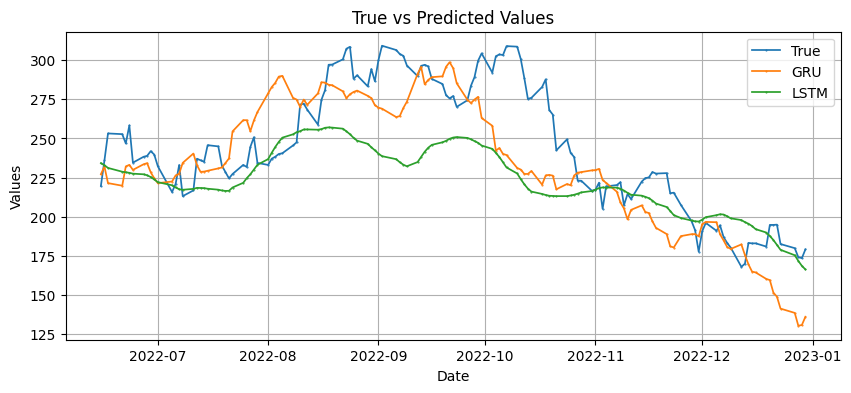

In [58]:
results['date'] = pd.to_datetime(results['date'])

plt.figure(figsize=(10, 4))
plt.plot(results['date'], results['true'], label='True', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['gru'], label='GRU', marker='.', linewidth=1.25, markersize=1)
plt.plot(results['date'], results['lstm'], label='LSTM', marker='.', linewidth=1.25, markersize=1)

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

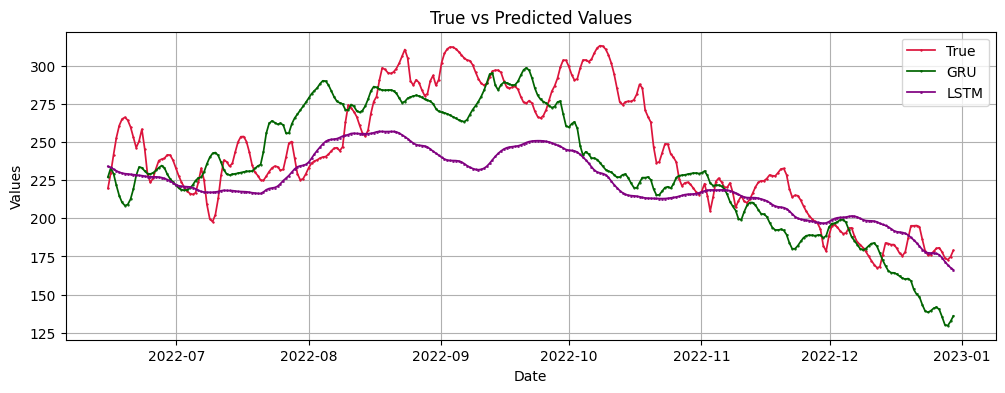

In [59]:
from scipy.interpolate import make_interp_spline

results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by='date')

smoothness = 3
xnew = pd.date_range(start=results['date'].min(), end=results['date'].max(), periods=300)
spl_gru = make_interp_spline(results['date'], results['gru'], k=smoothness)
spl_lstm = make_interp_spline(results['date'], results['lstm'], k=smoothness)
spl_true = make_interp_spline(results['date'], results['true'], k=smoothness)

plt.figure(figsize=(12, 4))
plt.plot(xnew, spl_true(xnew), label='True', marker='+', linewidth=1.25, markersize=1, color='crimson')
plt.plot(xnew, spl_gru(xnew), label='GRU', marker='v', linewidth=1.25, markersize=1, color='darkgreen')
plt.plot(xnew, spl_lstm(xnew), label='LSTM', marker='^', linewidth=1.25, markersize=1, color='purple')

plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### Next

In [71]:
df = data.copy()

In [83]:
x1  = df[df['date'] == '2022-06-16']['close'].values[0]

In [79]:
x1

233.0

In [80]:
true_val_scaled[0]

219.60000610351562

In [84]:
data[data['date'] == '2022-06-16']

,date,open,high,low,close,adj_close,volume,ma7,ma21,26ema,...,close_60,Log_Returns,Vola10d,Vola30d,Vola60d,Vol_Pct_Change,Volu10d_ff,Volu30d_ff,Volu60d_ff,atr
619,2022-06-16,222.736664,225.166672,208.693329,213.100006,213.100006,107390700,228.075714,233.501905,243.445443,...,288.075002,-0.089277,0.818938,0.864042,0.753879,-0.098556,2.643827,3.484852,4.572487,16.173571
